# Wine Case Analysis: *Wine Spectator*'s Top 100 Wines, 1988-2020
List available online on *Wine Spectator*'s [Top 100 Lists web site](https://top100.winespectator.com/lists/).

## File Setup

In [416]:
# import and initialize main python libraries
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import bar_chart_race as bcr
import seaborn as sns

# import libraries for file navigation
import os
import shutil
import glob
from pandas_ods_reader import read_ods

# import other packages
from scipy import stats
from sklearn import linear_model

# import geo packages
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

# import Geopy packages
import geopy
from geopy.geocoders import Nominatim

In [417]:
# initialize vizualization set
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
sns.mpl.rc("figure", figsize=(10, 6))

# Jupyter Notebook
%matplotlib inline

## Dataframe Exploration

In [418]:
# Note: save CSV files in UTF-8 format to preserve special characters.
df_Wine = pd.read_csv('./Wine_Hier00.csv')
df_GeoCache = pd.read_csv('./GeoCache.csv')
df_Flag = pd.read_csv('./emoji_list.csv')

In [419]:
df_Wine.shape

(3301, 25)

In [420]:
df_Wine.dtypes

Review_Year           float64
Rank                   object
Vintage                object
Score                 float64
Price                  object
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [421]:
# CSV of wines is retaining a blank row at the end of the dataset. Remove the last row to prevent data type errors.

# number of rows to drop
n = 1

df_Wine.drop(df_Wine.tail(n).index, inplace = True)

In [422]:
# Review_Year
# Convert Review_Year from float to int
df_Wine['Review_Year'] = df_Wine['Review_Year'].astype(int)

In [423]:
df_GeoCache.shape

(1224, 8)

In [424]:
df_Flag.shape

(19, 3)

In [425]:
df_Wine.sample(10)

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_from,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude
864,2012,65,2010,92.0,29,Nikolaihof,Grüner Veltliner Qualitätswein Trocken Wachau ...,White,Grüner,NaN,...,2012.0,2020.0,"This powerful, plush-tasting Grüner boasts con...",Hierarchy_00,Austria,Österreich,"(47.2000338, 13.199959, 0.0)",47.200034,13.199959,0.0
1121,2009,22,2007,94.0,38,Tensley,Syrah Santa Barbara County Colson Canyon Vineyard,Red,Shiraz | Syrah,NaN,...,2009.0,2016.0,"Firm and musclebound, with rich, chewy tannins...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
1343,2007,44,2004,93.0,40,Rubicon Estate,Zinfandel Rutherford Edizione Pennino,Red,Zinfandel,NaN,...,2007.0,2011.0,"Rich and loamy, with savory wild berry and bra...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
1408,2006,9,2004,96.0,70,Brancaia,Toscana Il Blu,Red,Blend,"Sangiovese, Merlot and Cabernet Sauvignon",...,2008.0,NaN,"The aromas leave me speechless, with freshly c...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0
2772,1993,73,1990,91.0,17,Château Fontenil,Fronsac,Red,Blend,Bordeaux Blend Red,...,1993.0,NaN,A classy wine that shows great winemaking. Fil...,Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
1954,2001,55,2000,92.0,30,Château Mont-Redon,Châteauneuf-du-Pape White,White,Châteauneuf-du-Pape,NaN,...,2001.0,2010.0,"White Châteauneuf with beautiful clean, fresh,...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
1920,2001,21,1998,93.0,22,Château Haut-Corbin,St.-Emilion,Red,Blend,Bordeaux Blend Red,...,2008.0,NaN,"Aromas of mineral, berry, flowers and cherry. ...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
3288,1988,89,1987,90.0,7,Husch,Gewürztraminer Anderson Valley,White,Gewürztraminer,NaN,...,NaN,NaN,Nearly identical to a fine Alsace Gewürz. Love...,Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
2626,1994,27,1990,93.0,41,Nozzole,Il Pareto,Red,Cabernet Sauvignon,NaN,...,1998.0,NaN,"A powerhouse, with deep color and super ripe, ...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0
1607,2004,8,1999,96.0,40,Greg Norman Estates,Shiraz South Eastern Australia Reserve,Red,Shiraz | Syrah,NaN,...,2006.0,NaN,"Dark, deep and powerful, an explosive wine, po...",Hierarchy_00,Australia,Australia,"(-24.7761086, 134.755, 0.0)",-24.776109,134.755000,0.0


## Vintage Wines where Cases Made was Non-Zero

In [426]:
# replace 'NaN' results in chart with 0 to facilitate analysis
df_Wine.fillna(value = 0, inplace = True)

In [427]:
# drop the non-numeric price row from the dataset
df_Wine = df_Wine[df_Wine.Price != '$49 / 500ml']

In [428]:
# Convert data type of price to numeric
df_Wine['Price'] = pd.to_numeric(df_Wine.Price, downcast = 'float')

In [429]:
df_Wine.dtypes

Review_Year             int64
Rank                   object
Vintage                object
Score                 float64
Price                 float32
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [430]:
# Remove Non-Vintage (NV) wines from df_Wine
# Include only wines with a Cases_Made value

df_Wine_V = df_Wine[
    (df_Wine.Vintage != 'NV')
]

df_Wine_V.shape

(3244, 25)

In [431]:
# Average Score by Wine Style - All Years
df_SWS_All = pd.DataFrame({'Avg_Score' : df_Wine_V.groupby(['Wine_Style'])['Score'].mean()}).reset_index()
df_SWS_All

,Wine_Style,Avg_Score
0,Dessert & Fortified,95.318841
1,Red,93.127455
2,Rosé | Rosado,90.444444
3,Sparkling,93.586957
4,White,91.980700


In [432]:
# Average Score by Wine Style - By Review Year
df_SWS_ByYear = pd.DataFrame({'Avg_Score' : df_Wine_V.groupby(['Review_Year', 'Wine_Style'])['Score'].mean()}).reset_index()
df_SWS_ByYear.sample(10)

,Review_Year,Wine_Style,Avg_Score
125,2020,Sparkling,93.333333
1,1988,Red,93.802632
35,1997,White,92.235294
95,2013,White,91.875000
11,1991,Dessert & Fortified,93.500000
74,2008,White,91.545455
108,2016,White,91.920000
75,2009,Dessert & Fortified,94.000000
79,2010,Dessert & Fortified,96.000000
87,2012,Red,93.301370


In [433]:
# Average Score by Wine Style - All Years
df_PWS_All = pd.DataFrame({'Avg_Price' : df_Wine_V.groupby(['Wine_Style'])['Price'].mean()}).reset_index()
df_PWS_All

,Wine_Style,Avg_Price
0,Dessert & Fortified,65.579712
1,Red,46.101704
2,Rosé | Rosado,24.777779
3,Sparkling,70.586960
4,White,29.078407


In [434]:
# Average Score by Wine Style - By Vintage Year
df_PWS_ByYear = pd.DataFrame({'Avg_Price' : df_Wine_V.groupby(['Review_Year', 'Wine_Style'])['Price'].mean()}).reset_index()
df_PWS_ByYear.sample(10)

,Review_Year,Wine_Style,Avg_Price
32,1997,Dessert & Fortified,70.000000
111,2017,Sparkling,33.000000
79,2010,Dessert & Fortified,48.666668
115,2018,Rosé | Rosado,20.000000
87,2012,Red,52.808220
2,1988,Sparkling,68.000000
25,1995,Red,42.545456
30,1996,Sparkling,29.000000
54,2003,Red,38.599998
119,2019,Red,63.000000


In [435]:
# Average Score by Address - All Years
df_SA_All = pd.DataFrame({'Avg_Score' : df_Wine_V.groupby(['Address'])['Score'].mean()}).reset_index()
df_SA_All

,Address,Avg_Score
0,Argentina,91.982456
1,Australia,92.390625
2,Austria,91.571429
3,Canada,94.000000
4,Chile,92.122807
5,France,93.618490
6,Germany,92.213115
7,Greece,90.272727
8,Hungary,94.250000
9,Israel,91.000000


In [436]:
# Average Score by Address - By Review Year
df_SA_ByYear = pd.DataFrame({'Avg_Score' : df_Wine_V.groupby(['Review_Year', 'Address'])['Score'].mean()}).reset_index()
df_SA_ByYear.sample(10)

,Review_Year,Address,Avg_Score
352,2020,Hungary,90.000000
231,2011,Greece,91.000000
327,2018,Italy,93.894737
270,2014,Germany,90.500000
317,2017,USA,93.290323
232,2011,Italy,93.050000
157,2005,Spain,92.166667
118,2002,Italy,93.428571
309,2017,Chile,93.500000
242,2012,France,93.380952


In [437]:
# Average Score by Wine Style - All Years
df_PA_All = pd.DataFrame({'Avg_Price' : df_Wine_V.groupby(['Address'])['Price'].mean()}).reset_index()
df_PA_All

,Address,Avg_Price
0,Argentina,37.473682
1,Australia,35.182293
2,Austria,25.821428
3,Canada,55.000000
4,Chile,39.385963
5,France,56.552082
6,Germany,25.852459
7,Greece,18.090910
8,Hungary,80.625000
9,Israel,37.142857


In [438]:
# Average Score by Wine Style - By Review Year
df_PA_ByYear = pd.DataFrame({'Avg_Price' : df_Wine_V.groupby(['Review_Year', 'Address'])['Price'].mean()}).reset_index()
df_PA_ByYear.sample(10)

,Review_Year,Address,Avg_Price
40,1994,France,39.933334
151,2005,France,66.000000
251,2013,Argentina,56.333332
76,1998,Austria,100.000000
39,1994,Australia,14.666667
170,2006,Spain,28.000000
155,2005,Portugal,20.750000
177,2007,Germany,32.500000
269,2014,France,68.428574
114,2002,Argentina,17.000000


### Visualization

In [439]:
# set palette and dimensions
palette = sns.color_palette('colorblind')

In [440]:
# define a function to graph summary data

def summary_barplot(price_or_score, style_or_address):
    
    if price_or_score == 'Price':
        if style_or_address == 'Wine_Style':
            df = df_PWS_All
        elif style_or_address == 'Address':
            df = df_PA_All
        else:
            print('select style or address')
    elif price_or_score == 'Score':
        if style_or_address == 'Wine_Style':
            df = df_SWS_All
        elif style_or_address == 'Address':
            df = df_SA_All
    else:
        print('price or score')
        
    g = sns.catplot(
        data = df,
        kind = 'bar',
        y = style_or_address,
        x = 'Avg_' + price_or_score
    )
    
    g.despine(left = True)
    g.set_axis_labels('Average ' + price_or_score, 'Wine Style')
    
    plt.suptitle('Average ' + price_or_score + ' by ' + style_or_address + ', 1988-2020', y = 1.1)
    plt.savefig('./images/catplot_avg_' + price_or_score + '_by_' + style_or_address + '.png')

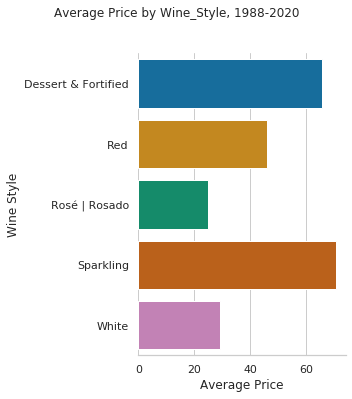

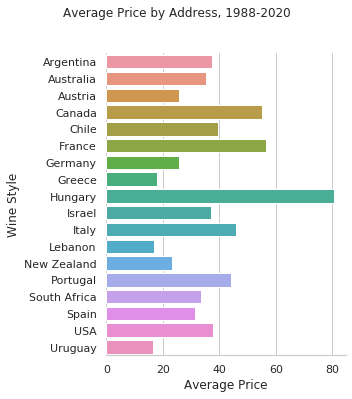

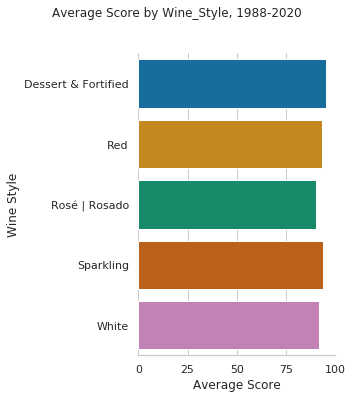

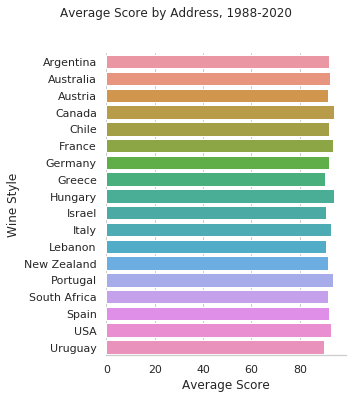

In [441]:
x_list = ['Price', 'Score']
y_list = ['Wine_Style', 'Address']

for x in x_list:
    for y in y_list:
        summary_barplot(x, y)

In [442]:
# define a function to graph summary data

def summary_boxplot(price_or_score, style_or_address):
    
    df = df_Wine_V
    
    sns.mpl.rc("figure", figsize=(15, 10))
    
    g = sns.boxplot(
        data = df,
        y = style_or_address,
        x = price_or_score,
        showmeans = True
    )
    
    plt.suptitle(price_or_score + ' by ' + style_or_address + ',/nReview Years 1988-2020')
    plt.savefig('./images/boxplot_' + price_or_score + '_by_' + style_or_address + '.png')

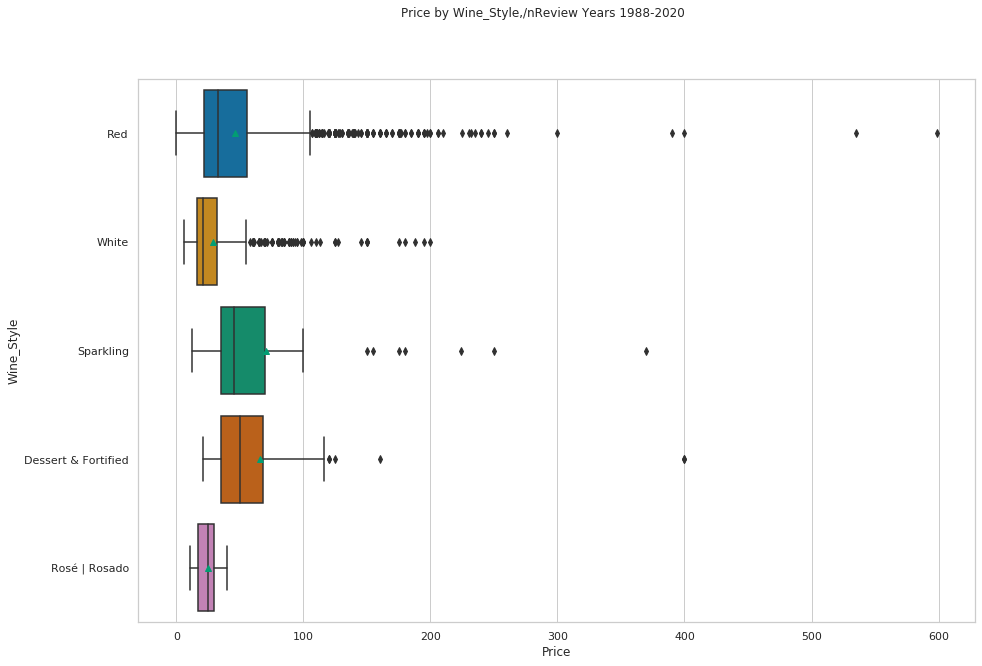

In [443]:
summary_boxplot('Price', 'Wine_Style')

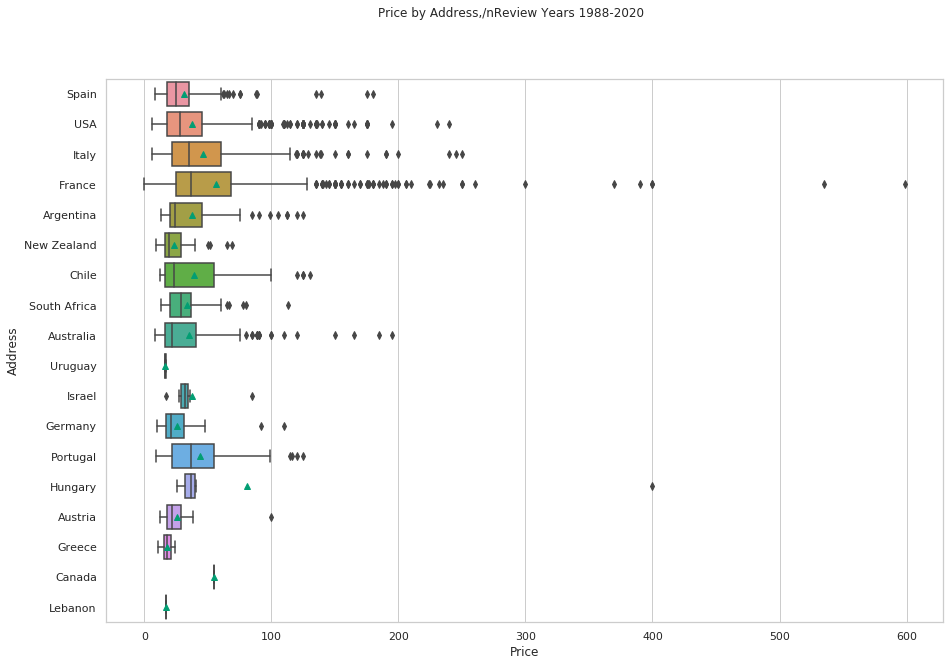

In [444]:
summary_boxplot('Price', 'Address')

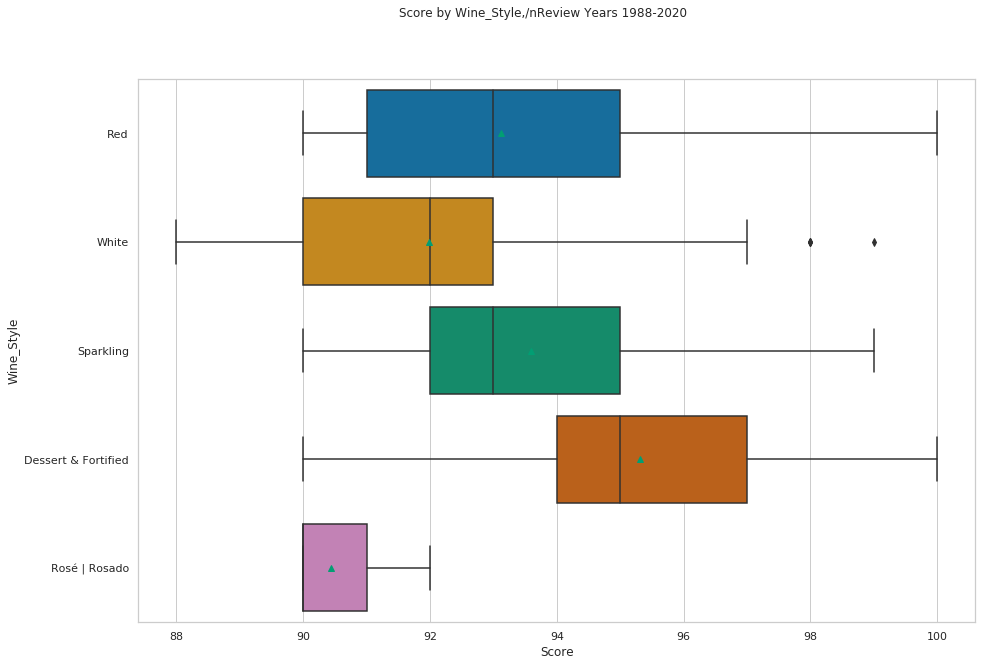

In [445]:
summary_boxplot('Score', 'Wine_Style')

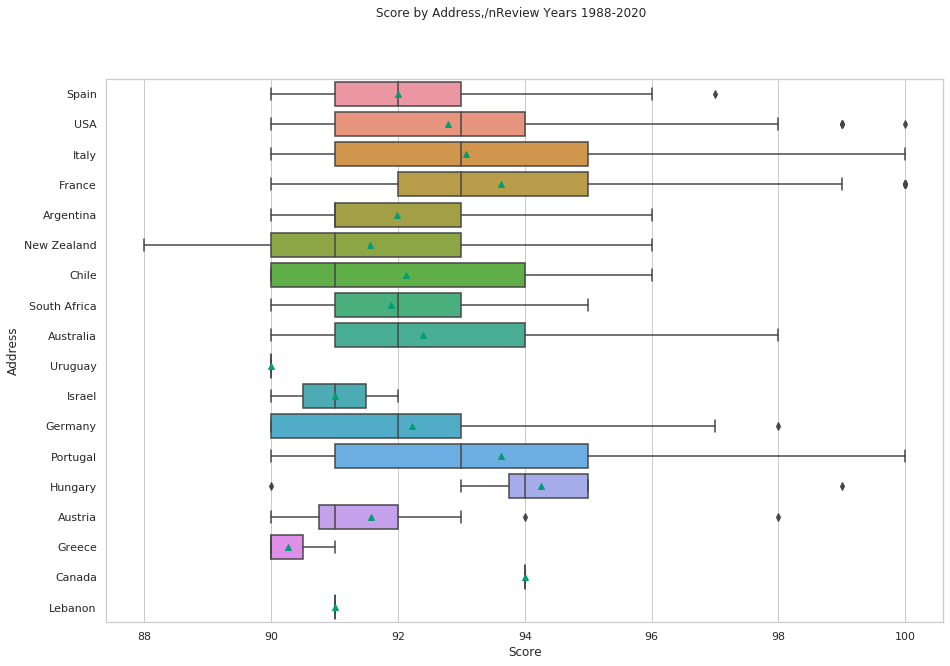

In [446]:
summary_boxplot('Score', 'Address')

In [447]:
# define a function to graph summary data by Review Year

def summary_by_year_lineplot(price_or_score, style_or_address):
    if price_or_score == 'Price':
        if style_or_address == 'Wine_Style':
            df = df_PWS_ByYear
        elif style_or_address == 'Address':
            df = df_PA_ByYear
        else:
            print('select style or address')
    elif price_or_score == 'Score':
        if style_or_address == 'Wine_Style':
            df = df_SWS_ByYear
        elif style_or_address == 'Address':
            df = df_SA_ByYear
    else:
        print('price or score')
        
    g = sns.relplot(
        data = df,
        y = 'Avg_' + price_or_score,
        x = 'Review_Year',
        col = style_or_address,
        col_wrap = 3,
        kind = 'line'
    )
    
    g.despine(left = True)
    g.set_axis_labels('Average ' + price_or_score, style_or_address)
    
    if style_or_address == 'Wine_Style':
        y = 1.05
    else: 
        y = 1.01
    
    plt.suptitle('Average ' + price_or_score + ' by ' + style_or_address + ' by Review Year', y = y)
    plt.savefig('./images/relplot_avg_' + price_or_score + '_by_' + style_or_address + '.png')

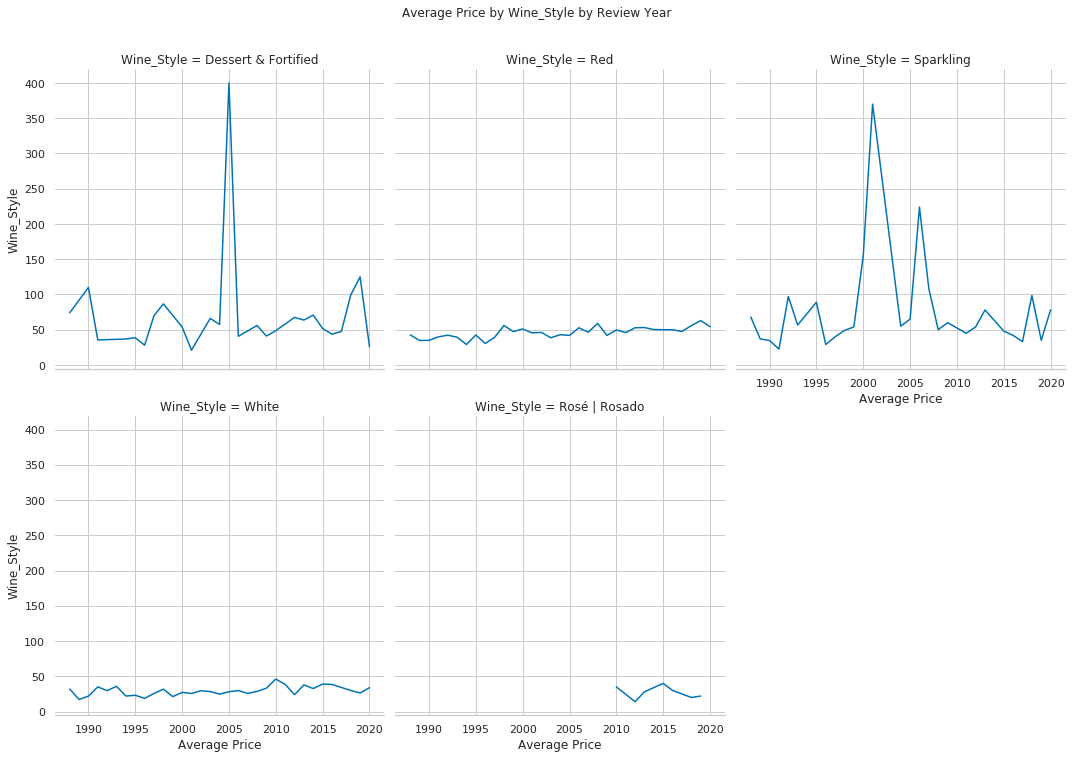

In [448]:
summary_by_year_lineplot('Price', 'Wine_Style')

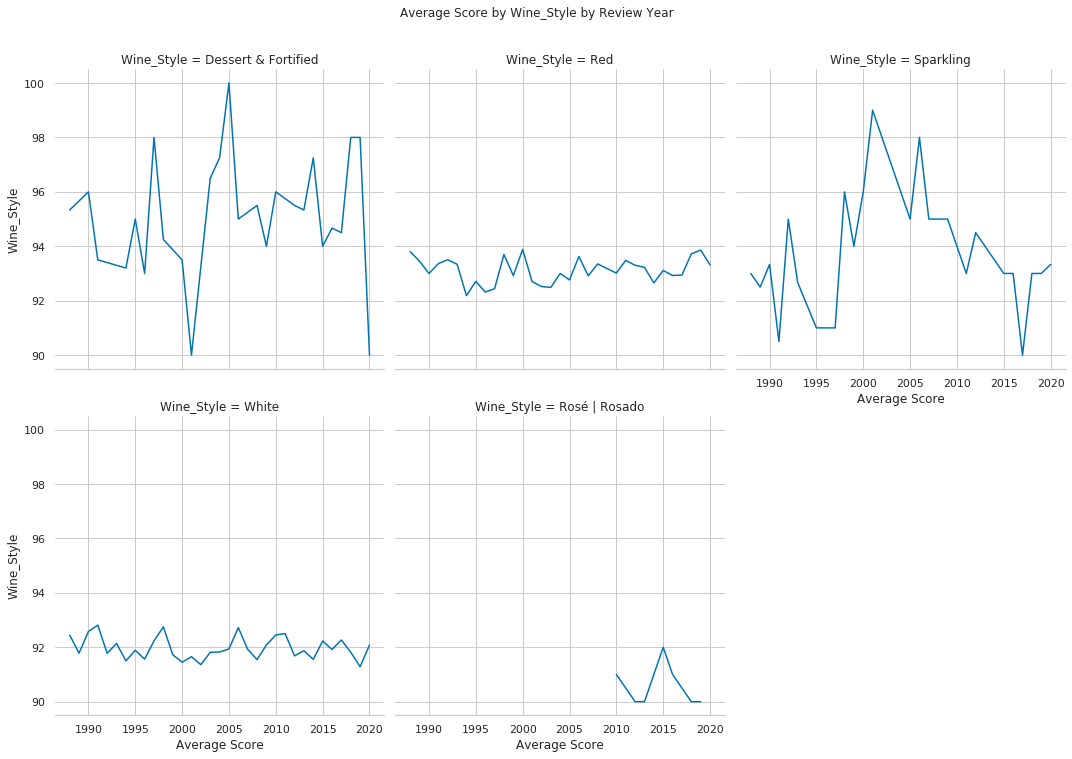

In [449]:
summary_by_year_lineplot('Score', 'Wine_Style')

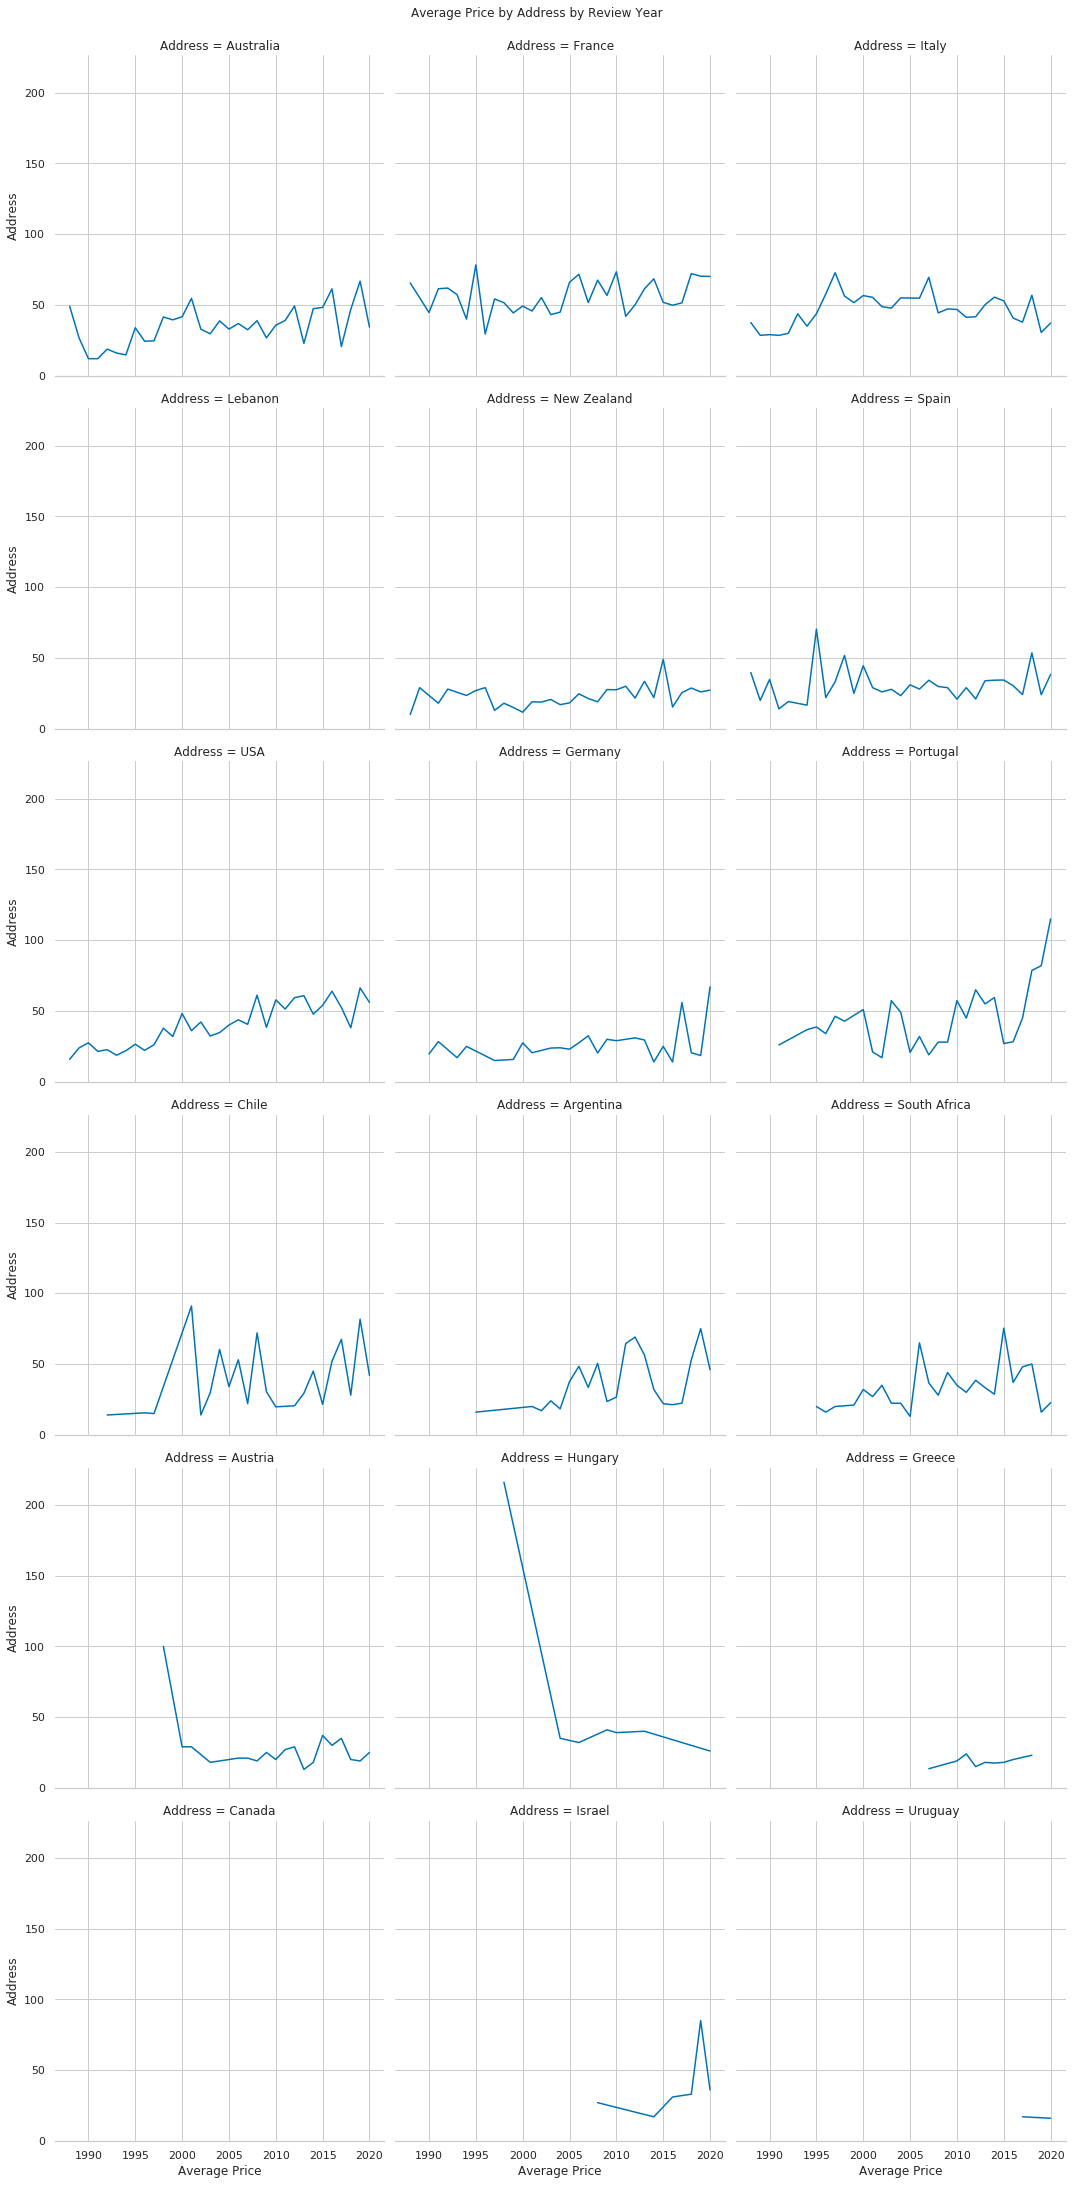

In [450]:
summary_by_year_lineplot('Price', 'Address')

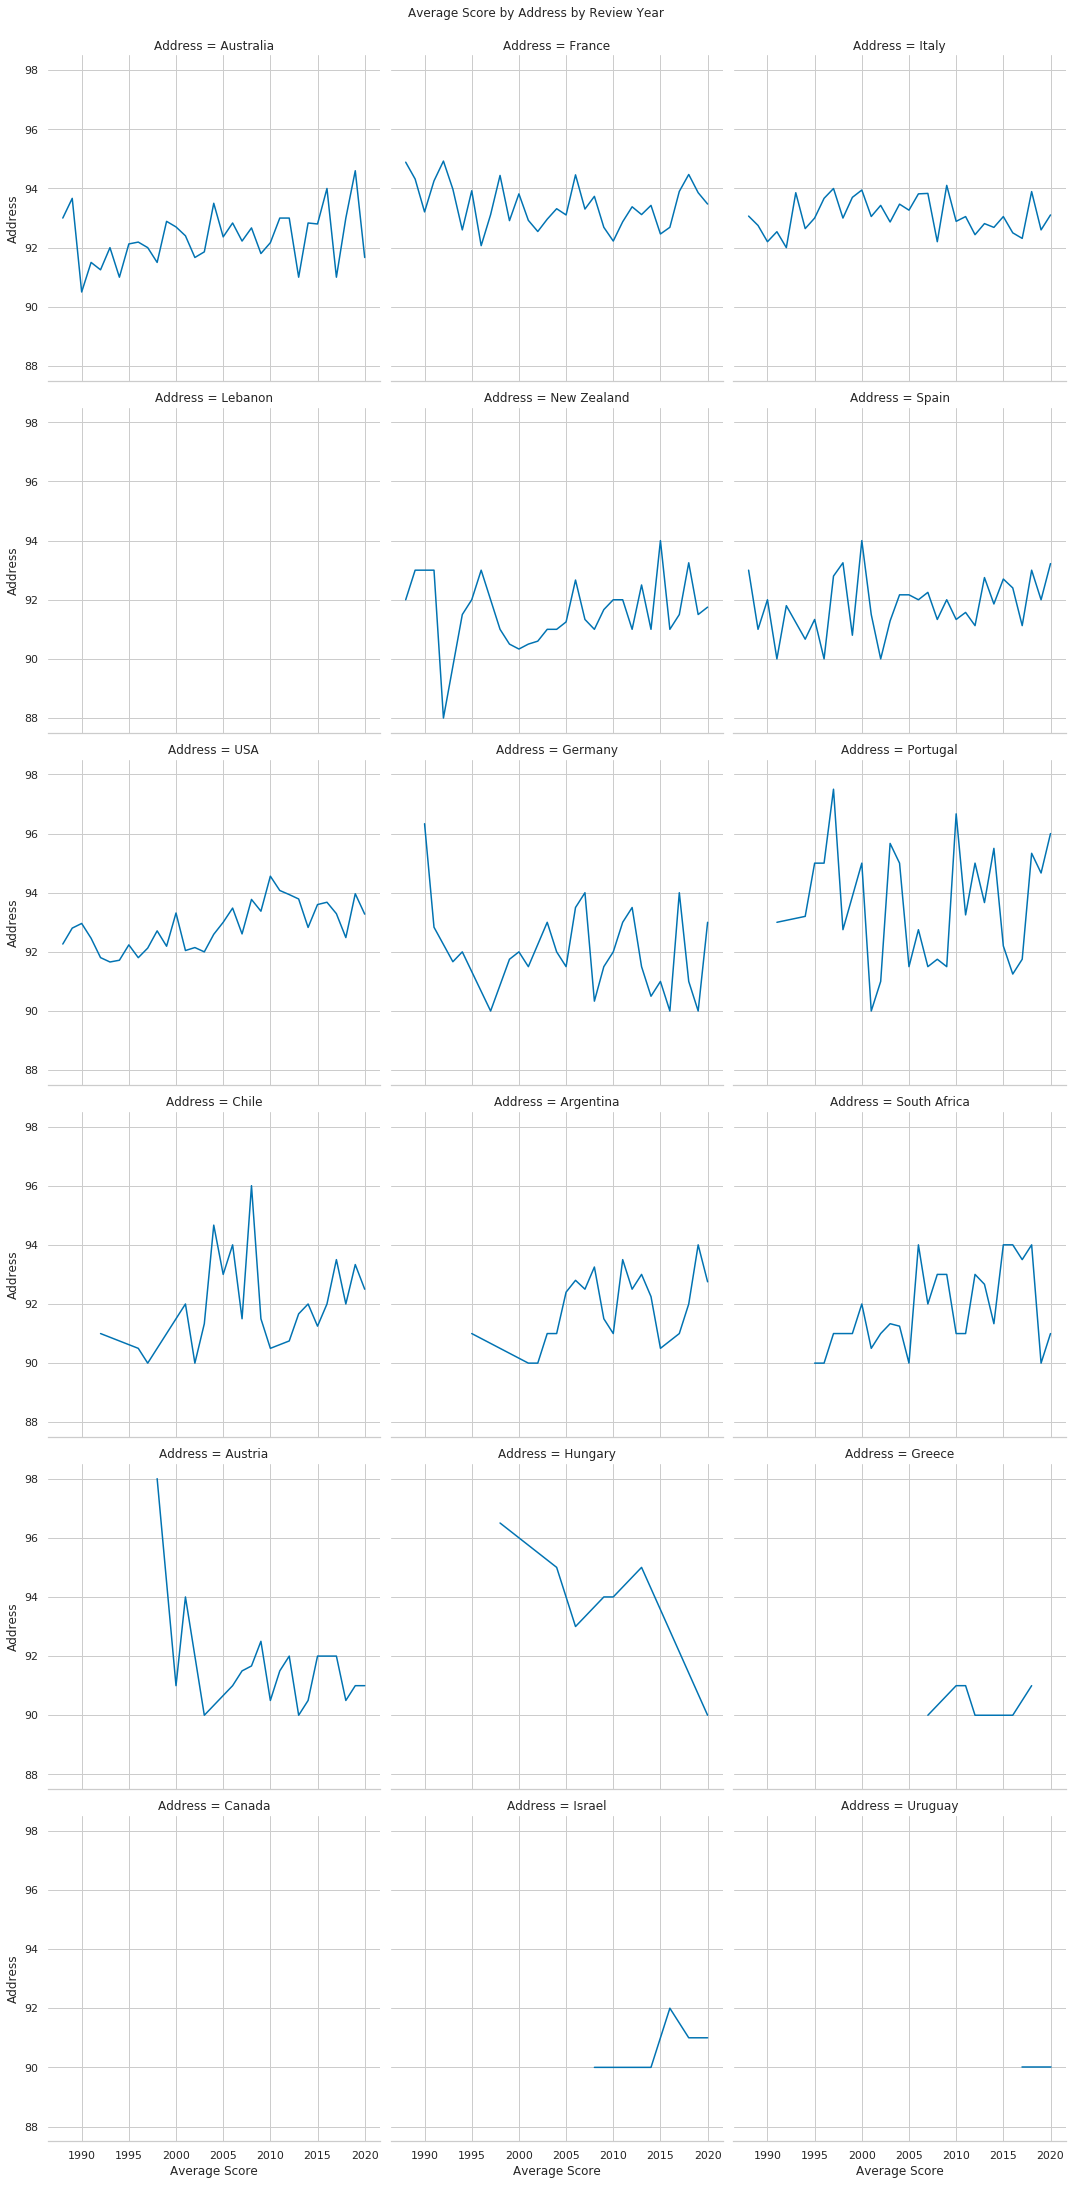

In [451]:
summary_by_year_lineplot('Score', 'Address')